In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation


In [2]:
# Detector size
det_row_count = 256
det_col_count = 256
pixel_size = 1.1230625


In [3]:
# place detector in xy plane, we shall align such that the
# optical axis is orthogonal to the detector plane, and, at
# the same time, the projeciton of the lab-z-axis will be
# along the v = d2 - d0 directon of the detector, such that
# the rows on the detector alwys correspond to moving along
# the vertical (z) direction.

x, y, z = np.eye(3)
eta = np.radians(20.232593)
theta = np.radians(15.416837)
Reta = Rotation.from_rotvec(x * eta).as_matrix()
Rtheta = Rotation.from_rotvec(-2 * y * theta).as_matrix()
xi, yi, zi = (Reta @ Rtheta @ np.eye(3)).T
ray_direction = optical_axis = xi

dr = pixel_size * det_row_count / 2.0
dc = pixel_size * det_col_count / 2.0
d0 = -y * dc - z * dr
d1 = d0 + y * det_col_count * pixel_size
d2 = d0 + z * det_row_count * pixel_size
detector_corners = np.array([d0, d1, d2]).T

# rotation 1 around the lab z axis
oxy = optical_axis[0:2] / np.linalg.norm(optical_axis[0:2])
alpha = np.arccos(y[0:2] @ oxy)
beta = np.pi / 2.0 - alpha
R_beta = Rotation.from_rotvec(z * beta).as_matrix()
detector_corners = R_beta @ detector_corners

# rotation 2 around the lab z x optical_axis direction
gamma = np.arccos(optical_axis @ z)
beta = np.pi / 2.0 - gamma
axis = np.cross(optical_axis, z)
axis /= np.linalg.norm(axis)
R_beta = Rotation.from_rotvec(axis * beta).as_matrix()
detector_corners = R_beta @ detector_corners

detector_corners += optical_axis.reshape(3, 1) * 100

d0, d1, d2 = detector_corners.T
u = (d1 - d0) / (np.linalg.norm(d1 - d0))
v = (d2 - d0) / (np.linalg.norm(d2 - d0))
alpha = np.arccos(optical_axis @ u)
beta = np.arccos(optical_axis @ v)

pz = z - ray_direction * (ray_direction @ z)
pz /= np.linalg.norm(pz)
assert np.allclose(u @ ray_direction, 0)
assert np.allclose(v @ ray_direction, 0)
assert np.allclose(v @ pz, 1)
assert np.allclose(u @ v, 0)
dnormal = np.cross(v, u)
dnormal /= np.linalg.norm(dnormal)

assert np.allclose(dnormal, -ray_direction)


In [4]:
d0, ray_direction

(array([ 124.50939291, -172.48583287,  -77.94436185]),
 array([ 0.85865881, -0.17725537,  0.4809216 ]))

In [5]:
d0, d1, d2 = detector_corners.T
dy = pixel_size * (d1 - d0) / np.linalg.norm(d1 - d0)
dz = pixel_size * (d2 - d0) / np.linalg.norm(d2 - d0)

detector_center = d0 + (dy * det_col_count / 2.0) + (dz * det_row_count / 2.0)

print(detector_center)

normalized_detector_center = detector_center / np.linalg.norm(detector_center)

print(
    "ray_direction @ normalized_detector_center ",
    ray_direction @ normalized_detector_center,
)
print("ray_direction @ normalized_detector_center ", ray_direction @ dy)
print("ray_direction @ d0 ", ray_direction @ d0)

[ 85.86588097 -17.72553687  48.09215974]
ray_direction @ normalized_detector_center  1.0
ray_direction @ normalized_detector_center  5.551115123125783e-17
ray_direction @ d0  100.0


In [6]:
import astra


def create_sino3d_gpu(data, proj_geom, vol_geom, returnData=True, gpuIndex=None):
    """Create a forward projection of an image (3D).

:param data: Image data or ID.
:type data: :class:`numpy.ndarray` or :class:`int`
:param proj_geom: Projection geometry.
:type proj_geom: :class:`dict`
:param vol_geom: Volume geometry.
:type vol_geom: :class:`dict`
:param returnData: If False, only return the ID of the forward projection.
:type returnData: :class:`bool`
:param gpuIndex: Optional GPU index.
:type gpuIndex: :class:`int`
:returns: :class:`int` or (:class:`int`, :class:`numpy.ndarray`) -- If ``returnData=False``, returns the ID of the forward projection. Otherwise, returns a tuple containing the ID of the forward projection and the forward projection itself, in that order.

"""

    if isinstance(data, np.ndarray):
        volume_id = astra.data3d.create('-vol', vol_geom, data)
    else:
        volume_id = data
    sino_id = astra.data3d.create('-sino', proj_geom, 0)
    algString = 'FP3D_CUDA'
    cfg = astra.creators.astra_dict(algString)
    #if not gpuIndex==None:
    #    cfg['option']={'GPUindex':gpuIndex, 'DetectorSuperSampling':2, 'VoxelSuperSampling':2, 'fsohflksjf':None}
    cfg['option']={'DetectorSuperSampling':1}
    cfg['ProjectionDataId'] = sino_id
    cfg['VolumeDataId'] = volume_id
    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)
    astra.algorithm.delete(alg_id)

    if isinstance(data, np.ndarray):
        astra.data3d.delete(volume_id)
    if returnData:
        return sino_id, astra.data3d.get(sino_id)
    else:
        return sino_id


class GpuProjector(object):
    """Project sample voxels along the CRL optical axis.

    This implementation uses astra-toolbox https://github.com/astra-toolbox/astra-toolbox, which
    implements ray tracing primitives in cuda that run on NVIDIA GPUs.

    Args:
        pixel_size (:obj:`float`): Side length of detector pixel in units of microns.
        det_row_count (:obj:`int`): Number of pixels along the detector rows (vertical).
        det_col_count (:obj:`int`): Number of pixels along the detector columns (horizontal).
        super_sampling (:obj:`int`): Number of points to trace per detector pixel. Defautls to 1.

    Attributes:
        pixel_size (:obj:`float`): Side length of detector pixel in units of microns.
        det_row_count (:obj:`int`): Number of pixels along the detector rows (vertical).
        det_col_count (:obj:`int`): Number of pixels along the detector columns (horizontal).
        super_sampling (:obj:`int`): Number of points to trace per detector pixel. Defautls to 1.

    """

    def __init__(
        self,
        pixel_size,
        det_row_count,
        det_col_count,
        super_sampling,
    ):
        assert super_sampling > 0, "The super sampling must be positive"
        assert isinstance(super_sampling, int), "The super sampling must be integer"
        assert (
            det_row_count % super_sampling == 0
        ), "The super sampling must divise the detector size in an integer number of blocks."
        assert (
            det_col_count % super_sampling == 0
        ), "The super sampling must divise the detector size in an integer number of blocks."
        self.pixel_size = pixel_size
        self.det_row_count = det_row_count
        self.det_col_count = det_col_count
        self.super_sampling = super_sampling

    def __call__(
        self,
        voxel_volume,
        voxel_size,
        ray_direction,
        detector_corners,
        translation=np.zeros((3,)),
    ):
        """Project the voxel volume along the optical axis.

        The rays are parallel to the optical axis. This uses astra-toolbox to compute
        path lengths of the rays though the voxel volume.

        NOTE: The coordinate system is defined in terms of the indexing='ij' convention. I.e any voxel
            array that is projected is assumed to have axis=0 along the sample x-axis the axis=1 along the
            sample y-axis and the axis=2 along the sample z-axis. The projection that is returned is viewed
            such that axis=0 is along negative imaging z-axis and axis=1 is along negative imaging y-axis.
            I.e the produced image corresponds to looking up at the camera from the crl exit point.

        Args:
            voxel_volume (:obj:`numpy array`): The voxel data array. shape=(m,n,o).
            voxel_size (:obj:`float`): Side length of sample voxel in units of microns.
            ray_direction (:obj:`numpy array`): The propagation direction of the rays. shape=(3,)
            detector_corners (:obj:`numpy array`): The corners of the detector in microns. shape=(3,3).
                Each column is a corner as: [d0,d1,d2] where d0 is the bottom right corner (as viewed
                from the crl opening). d1 is to the left of d0 and d2 above d0. d0,d1,d2 is arranged counter
                clockwise. The vector from d0 to d1 defined the negative columns of the detector and the
                vector from d0 to d2 defines the negative rows.
            translation (:obj:`numpy array`): The translation (x,y,z) of the sample in microns. shape=(3,)

        Returns:
            :obj:`numpy array`: The projected image. shape=(det_row_count, det_col_count).

        """

        projection_image = self._project(
            voxel_volume,
            voxel_size,
            ray_direction,
            detector_corners,
            translation,
        )
        projection_image = self._bin_projection(projection_image)
        return projection_image

    def backproject(
        self,
        detector_image,
        voxel_volume_shape,
        voxel_size,
        ray_direction,
        detector_corners,
        translation=np.zeros((3,)),
    ):
        """Backpropagate the pixel values of a detector image to the sample volume.

        This is identical to a tomographic backprojection operation.

        Args:
            detector_image (:obj:`np.ndarray`): The 2d image to be backprojected. shape=(a,b)
            voxel_volume_shape (:obj:`tuple` of :obj:`int`): The sample voxel volume shape.
            voxel_size (:obj:`float`): Side length of sample voxel in units of microns.
            ray_direction (:obj:`numpy array`): The propagation direction of the rays. shape=(3,)
            detector_corners (:obj:`numpy array`): The corners of the detector in microns. shape=(3,3).
                Each column is a corner as: [d0,d1,d2] where d0 is the bottom right corner (as viewed
                from the crl opening). d1 is to the left of d0 and d2 above d0. d0,d1,d2 is arranged counter
                clockwise. The vector from d0 to d1 defined the negative columns of the detector and the
                vector from d0 to d2 defines the negative rows.
            translation (:obj:`numpy array`): The translation (x,y,z) of the sample in microns. shape=(3,)

        Returns:
            :obj:`np.ndarray`: The voxel volume populated by the backprojected values of detector_image.
        """
        m, n, o = voxel_volume_shape
        a, b = detector_image.shape

        n_slices, n_rows, n_cols = o, n, m
        vol_geom = astra.create_vol_geom((n_rows, n_cols, n_slices))

        vol_geom = astra.functions.move_vol_geom(vol_geom, translation)

        proj_geom = self._get_astra_projector(
            voxel_size,
            ray_direction,
            detector_corners,
            super_sampling=1,
        )
        sinogram = detector_image.reshape(a, 1, b)

        vol_id, vol = astra.creators.create_backprojection3d_gpu(
            sinogram,
            proj_geom,
            vol_geom,
            returnData=True,
        )

        vol = vol.swapaxes(0, 2)

        astra.data3d.delete(vol_id)

        return vol

    def _bin_projection(self, projection_image):
        """bin the image if super sampling was selected."""
        if self.super_sampling > 1:
            # each super_sampling x super_sampling block in the image is averaged
            # such that the new image size is reducde by the factor super_sampling
            # along both axis=0 and axis=1.
            m, n = projection_image.shape
            k = self.super_sampling
            projection_image = projection_image.reshape(m // k, k, n // k, k)
            projection_image = projection_image.sum(axis=(1, 3)) / (k**2)
        return projection_image

    def _project(
        self,
        voxel_volume,
        voxel_size,
        ray_direction,
        detector_corners,
        translation,
    ):
        """Project a voxel volume block on gpu."""
        proj_geom = self._get_astra_projector(
            voxel_size,
            ray_direction,
            detector_corners,
            self.super_sampling,
        )
        astra_voxel_volume = np.swapaxes(voxel_volume, 0, 2)
        n_slices, n_rows, n_cols = astra_voxel_volume.shape
        vol_geom = astra.create_vol_geom((n_rows, n_cols, n_slices))

        vol_geom = astra.functions.move_vol_geom(vol_geom, translation)
        sino_id, sino = create_sino3d_gpu(astra_voxel_volume, proj_geom, vol_geom)
        astra.data3d.delete(sino_id)
        return sino[:, 0, :]

    def _get_astra_projector(
        self,
        voxel_size,
        ray_direction,
        detector_corners,
        super_sampling,
    ):
        """Get astra vector geometry in lab frame."""
        vectors = self._get_astra_vectors(
            voxel_size,
            ray_direction,
            detector_corners,
            super_sampling,
        )
        nc = super_sampling * self.det_col_count
        nr = super_sampling * self.det_row_count
        proj_geom = astra.create_proj_geom("parallel3d_vec", nc, nr, vectors)
        return proj_geom

    def _get_astra_vectors(
        self,
        voxel_size,
        ray_direction,
        detector_corners,
        super_sampling,
    ):
        """Get astra vector geometry in lab frame.

        The vector geometry corresponds to projecting aling the optical axis.

        """

        # 3D corner coordinates of the detector
        d0, d1, d2 = detector_corners.T

        dy = self.pixel_size * (d1 - d0) / np.linalg.norm(d1 - d0)
        dz = self.pixel_size * (d2 - d0) / np.linalg.norm(d2 - d0)

        # 3D center coordinates of the detector
        print("d0", d0)

        detector_center = (
            d0 + (dy * self.det_col_count / 2.0) + (dz * self.det_row_count / 2.0)
        )

        # For precision in astra, does not change the projection.
        normalized_detector_center = detector_center / np.linalg.norm(detector_center)

        # vector from pixel (0,0) to (0,1) i.e detector cols
        u = -dy / (voxel_size * super_sampling)

        # vector from pixel (0,0) to (1,0) i.e detector rows
        v = -dz / (voxel_size * super_sampling)

        return np.concatenate(
            (ray_direction, normalized_detector_center, u, v)
        ).reshape(1, 12)

In [22]:
data = np.ones((33, 33, 1))
data[:, :, 0] = 1
projector = GpuProjector(
    pixel_size,
    det_row_count,
    det_col_count,
    super_sampling=1,
)

translation = np.array([0, 0, 0])


In [23]:
data.shape

(33, 33, 1)

d0 [ 124.50939291 -172.48583287  -77.94436185]


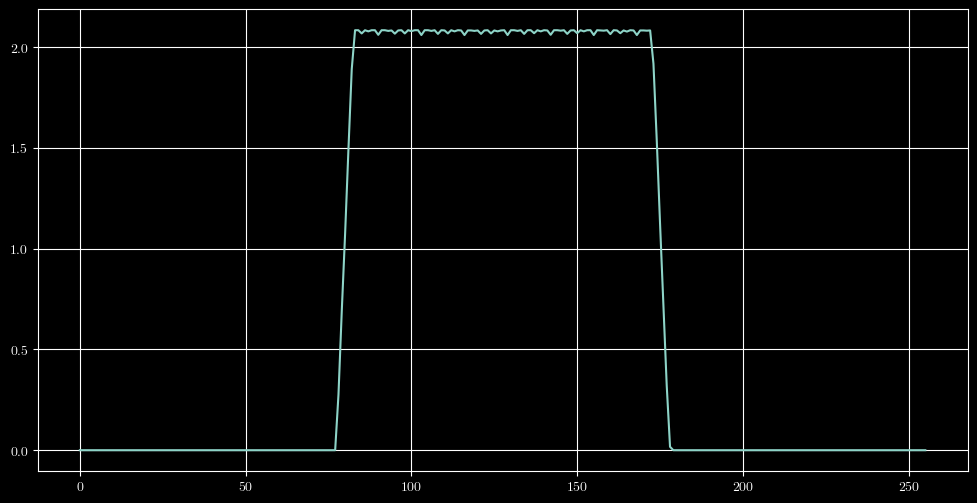

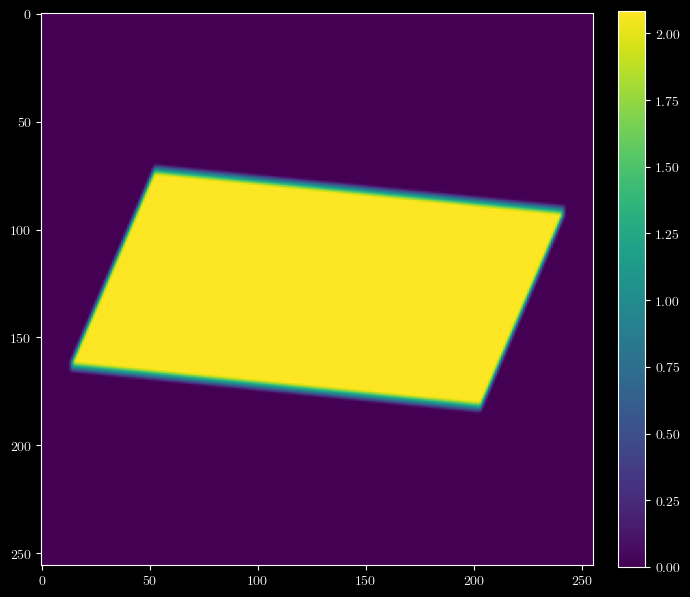

In [30]:

voxel_super_sampling = 4
vv = np.repeat(data, voxel_super_sampling, axis=0)
vv = np.repeat(vv, voxel_super_sampling, axis=1)
vv = np.repeat(vv, voxel_super_sampling, axis=2)

image = projector._project(
    vv,
    0.4375 * 15.1  / voxel_super_sampling ,
    ray_direction,
    detector_corners,
    translation,
) / 4

# image = projector(
#     data,
#     0.4375 *  15.1,
#     ray_direction,
#     detector_corners,
#     translation,
# )

plt.figure(figsize=(12, 6))
plt.plot(image[:, 128 * projector.super_sampling])
plt.grid(True)
plt.show()
plt.style.use("dark_background")
fig, ax = plt.subplots(1, 1, figsize=(7, 14))

im = ax.imshow(image, cmap="viridis")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()